In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
import matplotlib
matplotlib.rc('font', size=18)

import pandas as pd
import xarray as xr
from scipy.stats import linregress
from tqdm.notebook import tqdm

import sys
sys.path.append('../')

from general_purpose import cartopy_plots as cplt

# Visualize

In [2]:
ts = xr.open_dataset('HEAVY--Land_and_Ocean_LatLong1.nc')
ts

<xarray.Dataset>
Dimensions:      (longitude: 360, latitude: 180, time: 2078, month_number: 12)
Coordinates:
  * longitude    (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude     (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * time         (time) float64 1.85e+03 1.85e+03 ... 2.023e+03 2.023e+03
Dimensions without coordinates: month_number
Data variables:
    land_mask    (latitude, longitude) float64 ...
    temperature  (time, latitude, longitude) float32 ...
    climatology  (month_number, latitude, longitude) float32 ...
Attributes:
    Conventions:           Berkeley Earth Internal Convention (based on CF-1.5)
    title:                 Native Format Berkeley Earth Surface Temperature A...
    history:               22-Mar-2023 06:54:41
    institution:           Berkeley Earth Surface Temperature Project
    land_source_history:   05-Mar-2023 08:24:35
    ocean_source_history:  22-Mar-2023 05:21:28
    comment:               This file contains Berkeley Earth surface temperat...

In [3]:
LON,LAT = np.meshgrid(ts.longitude.data,ts.latitude.data)

## Plot the land_mask

/home/alessandro/anaconda3/envs/ml/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = super().pcolormesh(*args, **kwargs)


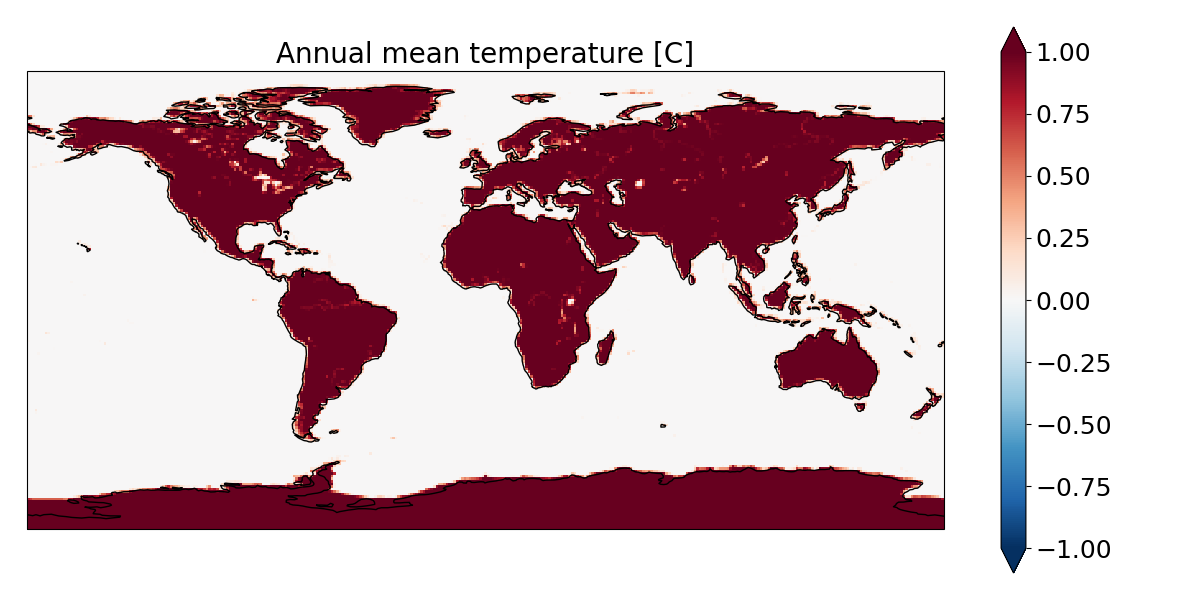

In [4]:
cplt.mfp(LON, LAT, ts.land_mask.data.reshape(*ts.land_mask.shape,1),
         figsize=(12,6),
         # draw_coastlines=False,
         projections=cplt.ccrs.PlateCarree(),
         colorbar='shared',
         extents=None,
         titles=['Annual mean temperature [C]'],
        )

/media/alessandro/OS/Users/ale57/Documents/0. Lyon/WORK/REA-Veros/veros-noise-product/../general_purpose/cartopy_plots.py:138: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  plt.colorbar(im, label=colorbar_label, extend='both')


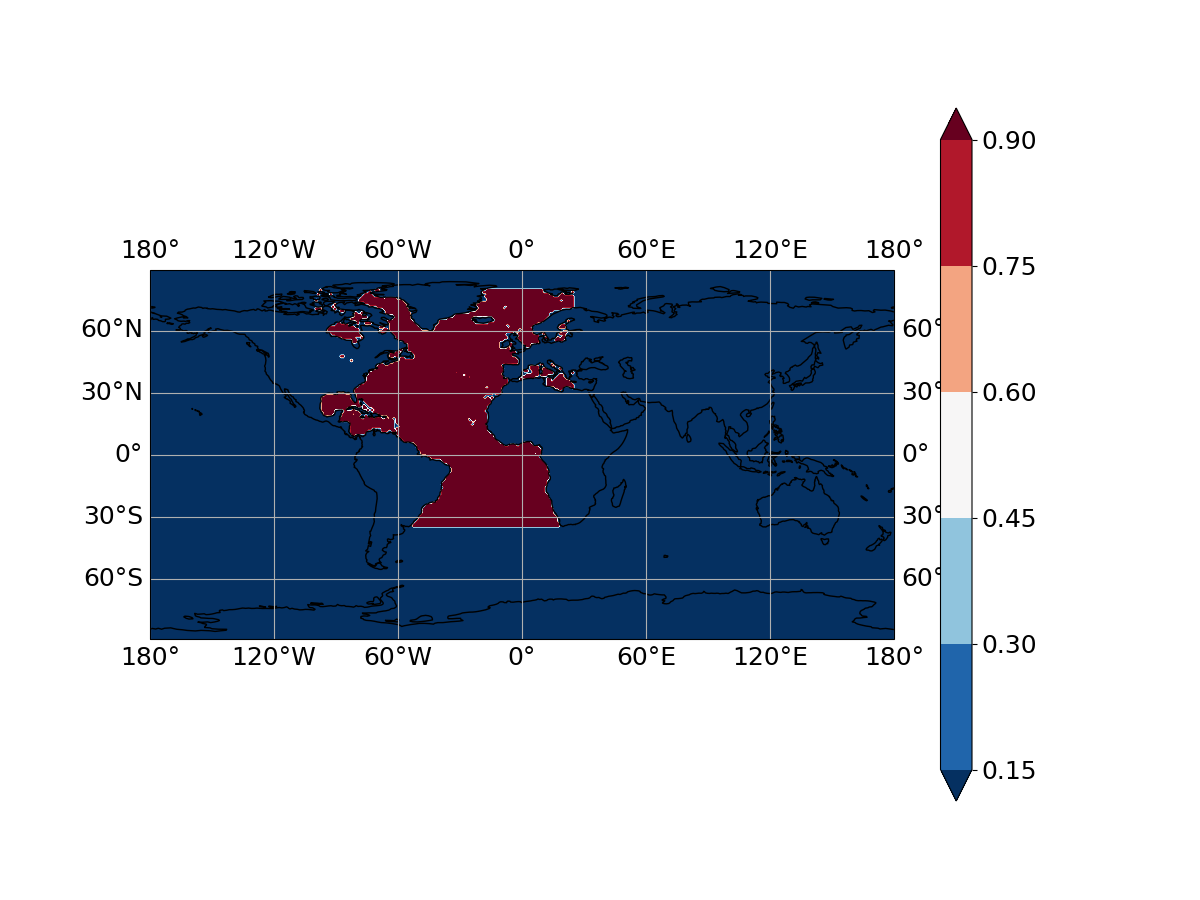

In [12]:
ocean_mask = ts.land_mask == 0
atlantic_mask = ocean_mask.copy()

# mask out everything below 35 deg south
atlantic_mask[atlantic_mask.latitude < -35] = False
atlantic_mask[atlantic_mask.latitude > 80] = False

atlantic_mask[:,atlantic_mask.longitude > 25] = False
atlantic_mask[:,atlantic_mask.longitude < -120] = False

for i in range(atlantic_mask.shape[0]):
    if atlantic_mask.latitude[i] > 20 or atlantic_mask.latitude[i] < -35:
        continue
    j = np.argmax(atlantic_mask.data[i])
    while atlantic_mask.data[i,j]:
        j += 1
    atlantic_mask[i,:j] = False
    
atlantic_mask[:, atlantic_mask.longitude < -100] = False

atlantic_mask[atlantic_mask.latitude < 16, atlantic_mask.longitude < -90] = False

atlantic_mask[atlantic_mask.latitude < 8, atlantic_mask.longitude < -73] = False

plt.close(2)
fig = plt.figure(num=2, figsize=(12,9))
ax = fig.add_subplot(111, projection=cplt.ccrs.PlateCarree())

cplt.geo_plotter(ax, LON, LAT,
                 atlantic_mask,
                 greenwich=True,
                 # draw_gridlines=False, draw_labels=False,
                 put_colorbar=True
                )

## Plot the climatology

In [14]:
ts.climatology.shape

(12, 180, 360)

/home/alessandro/anaconda3/envs/ml/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = super().pcolormesh(*args, **kwargs)
/home/alessandro/anaconda3/envs/ml/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = super().pcolormesh(*args, **kwargs)
/home/alessandro/anaconda3/envs/ml/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1785: Matp

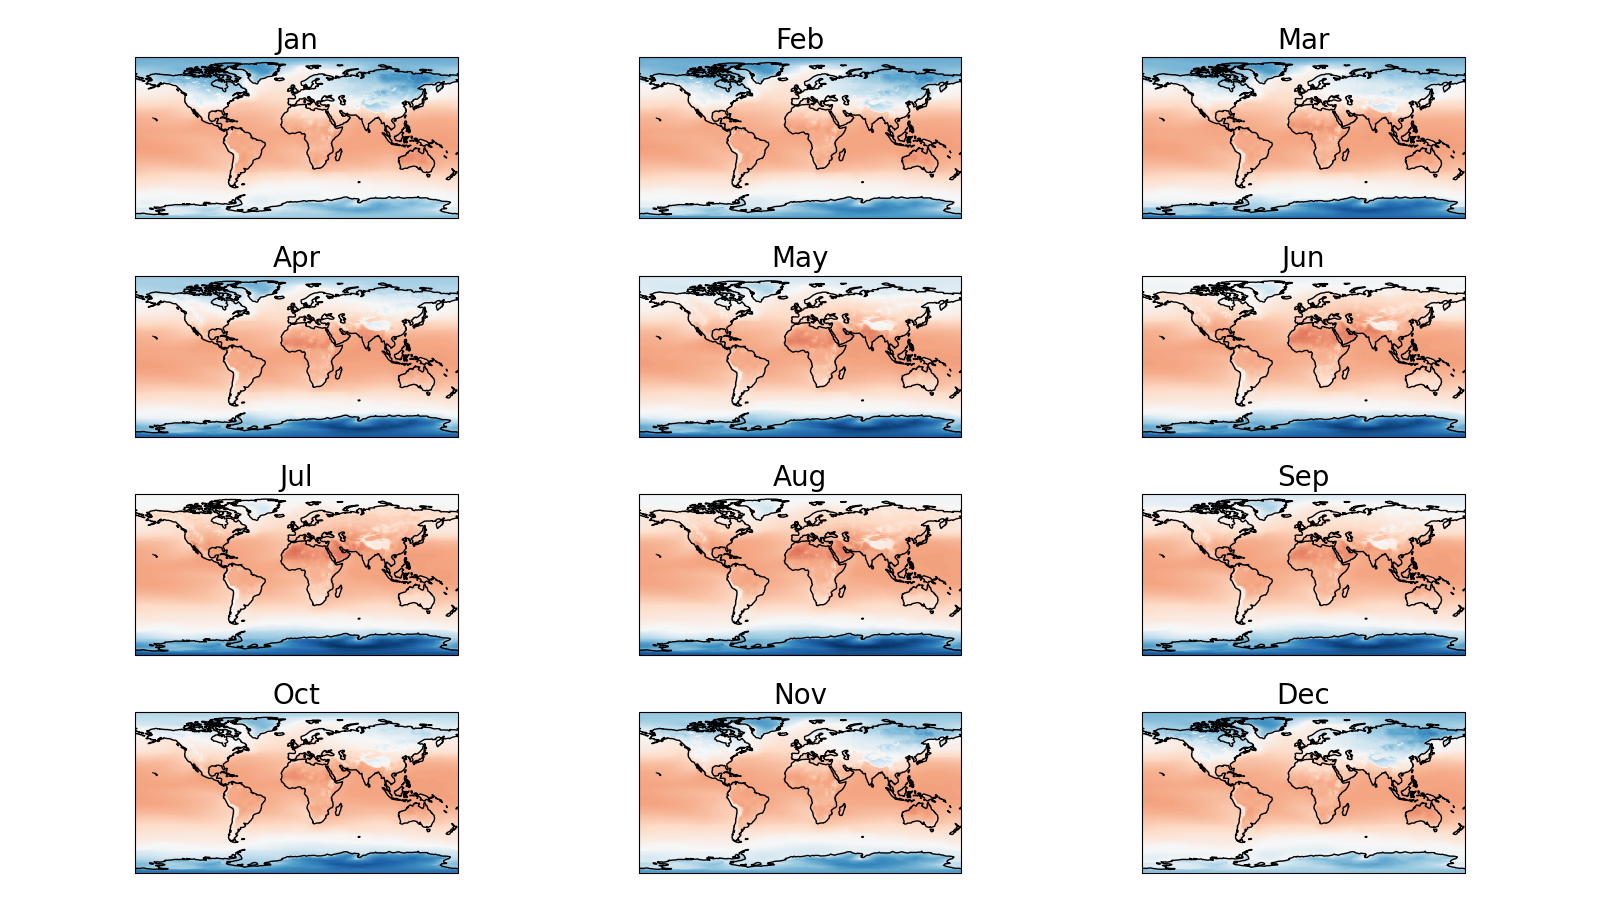

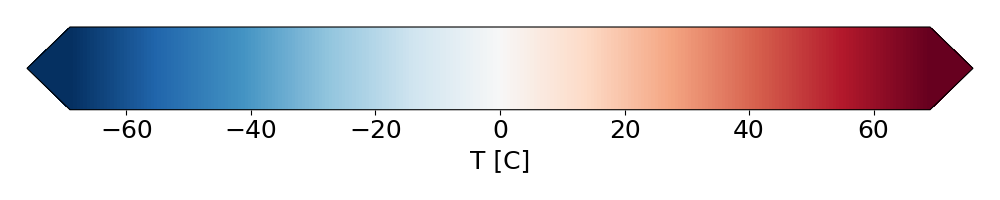

In [15]:
months=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
ofl = (4,3)
ims = cplt.mfp(LON, LAT, ts.climatology.data.transpose(1,2,0),
               figsize=(16,9),
               one_fig_layout=ofl,
               # draw_coastlines=False,
               projections=cplt.ccrs.PlateCarree(),
               colorbar='shared',
               put_colorbar=False,
               extents=None,
               titles=months,
              )

plt.close(3)
fig,ax = plt.subplots(num=3, figsize=(10,2))
plt.colorbar(ims[0],cax=ax,orientation='horizontal', extend='both', label='T [C]')
fig.tight_layout()

### Compute climatology anomaly

In [ ]:
mean = ts.climatology.mean('month_number')

In [ ]:
cplt.mfp(LON, LAT, mean.data.reshape(*mean.shape,1),
         figsize=(12,6),
         # draw_coastlines=False,
         projections=cplt.ccrs.PlateCarree(),
         colorbar='shared',
         extents=None,
         titles=['Annual mean temperature [C]'],
         draw_labels=True,
         draw_gridlines=True
        )

In [ ]:
ano_clim = ts.climatology - mean

In [ ]:
months=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
ofl = (4,3)
cplt.mfp(LON, LAT, ano_clim.data.transpose(1,2,0),
         figsize=(16,9),
         one_fig_layout=ofl,
         # draw_coastlines=False,
         projections=cplt.ccrs.PlateCarree(),
         colorbar='shared',
         extents=None,
         titles=months,
        )

## Plot a few snapshots

In [ ]:
ts.temperature.shape

/home/alessandro/anaconda3/envs/ml/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = super().pcolormesh(*args, **kwargs)
/home/alessandro/anaconda3/envs/ml/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = super().pcolormesh(*args, **kwargs)
/home/alessandro/anaconda3/envs/ml/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1785: Matp

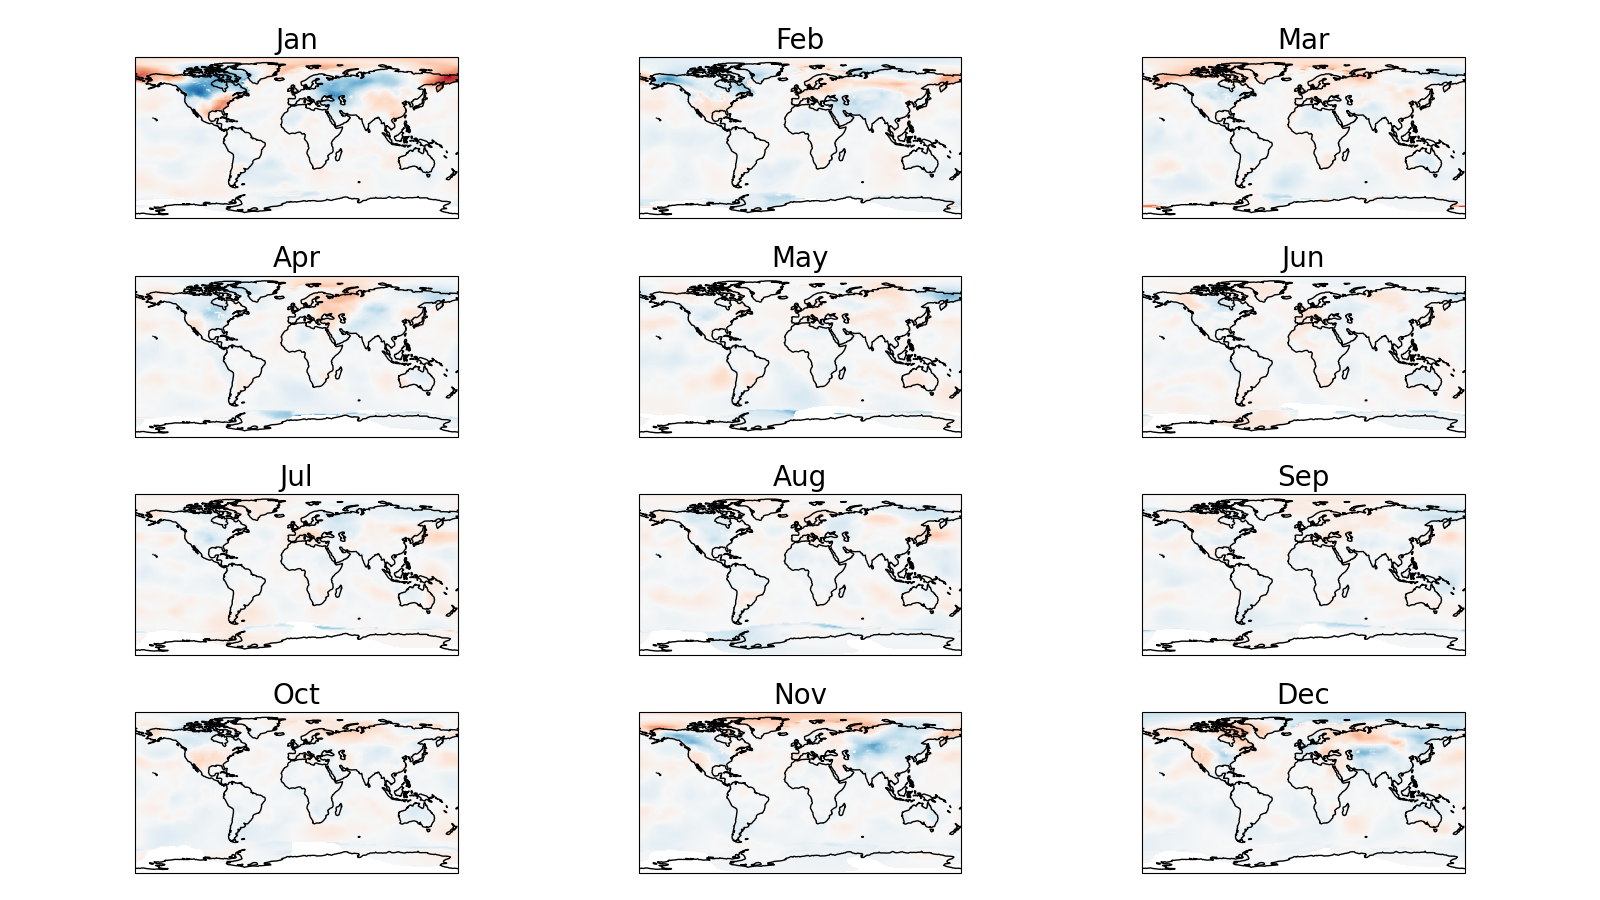

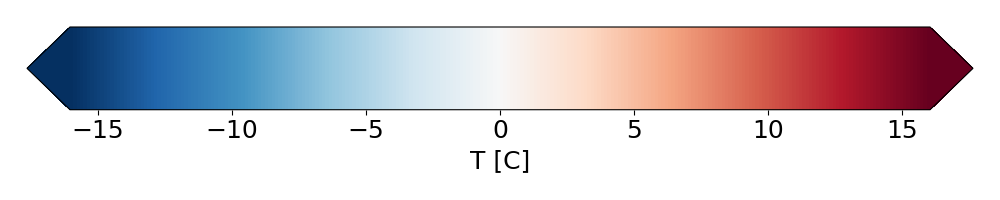

In [16]:
i = 12*100
ofl = (4,3)
ims = cplt.mfp(LON, LAT, ts.temperature.data[i:i+np.prod(ofl)].transpose(1,2,0),
               figsize=(16,9),
               one_fig_layout=ofl,
               # draw_coastlines=False,
               projections=cplt.ccrs.PlateCarree(),
               colorbar='shared',
               put_colorbar=False,
               extents=None,
               titles=months,
              )

plt.close(3)
fig,ax = plt.subplots(num=3, figsize=(10,2))
plt.colorbar(ims[0],cax=ax,orientation='horizontal', extend='both', label='T [C]')
fig.tight_layout()

In [ ]:
plt.close(19)
plt.figure(figsize=(9,6), num=19)
ts.temperature.isel(latitude=125, longitude=200).plot()
plt.plot(ts.time.data, ts.temperature.isel(longitude=200, latitude=125).data - ano_clim_periodic[:,125,200])
fig.tight_layout()

In [18]:
pn = ts.temperature.isnull().mean(['longitude','latitude'])

In [19]:
pno = ts.temperature.where(ocean_mask).isnull().mean(['longitude','latitude']) - (1 - np.mean(ocean_mask))

In [20]:
pna = ts.temperature.where(atlantic_mask).isnull().mean(['longitude','latitude']) - (1 - np.mean(atlantic_mask))

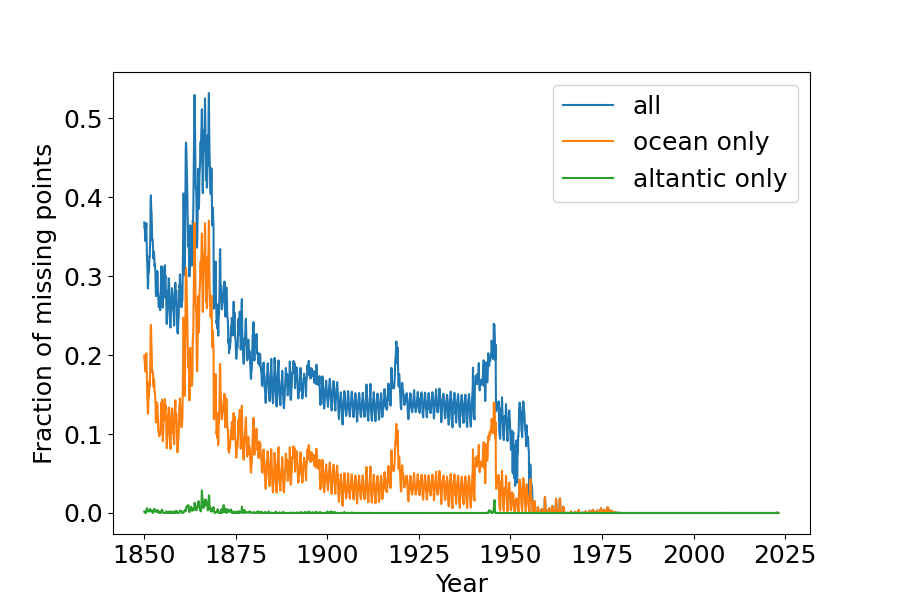

In [21]:
plt.close(4)
fig,ax = plt.subplots(figsize=(9,6), num=4)
pn.plot(label='all')
pno.plot(label='ocean only')
pna.plot(label='altantic only')
plt.ylabel('Fraction of missing points')
plt.xlabel('Year')
plt.legend()

## Remove the data before 1880

In [47]:
first_year = 1880
plt.axvline(first_year, color='red')
ts = ts.sel(time=slice(first_year,None))
ts

<xarray.Dataset>
Dimensions:      (longitude: 360, latitude: 180, time: 1718, month_number: 12)
Coordinates:
  * longitude    (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude     (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * time         (time) float64 1.88e+03 1.88e+03 ... 2.023e+03 2.023e+03
Dimensions without coordinates: month_number
Data variables:
    land_mask    (latitude, longitude) float64 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0
    temperature  (time, latitude, longitude) float32 nan nan nan ... 2.879 2.876
    climatology  (month_number, latitude, longitude) float32 -27.87 ... -30.91
Attributes:
    Conventions:           Berkeley Earth Internal Convention (based on CF-1.5)
    title:                 Native Format Berkeley Earth Surface Temperature A...
    history:               22-Mar-2023 06:54:41
    institution:           Berkeley Earth Surface Temperature Project
    land_source_history:   05-Mar-2023 08:24:35
    ocean_source_history:  22-Mar-2023 05:21:28
    comment:               This file contains Berkeley Earth surface temperat...

### Plot a few time series

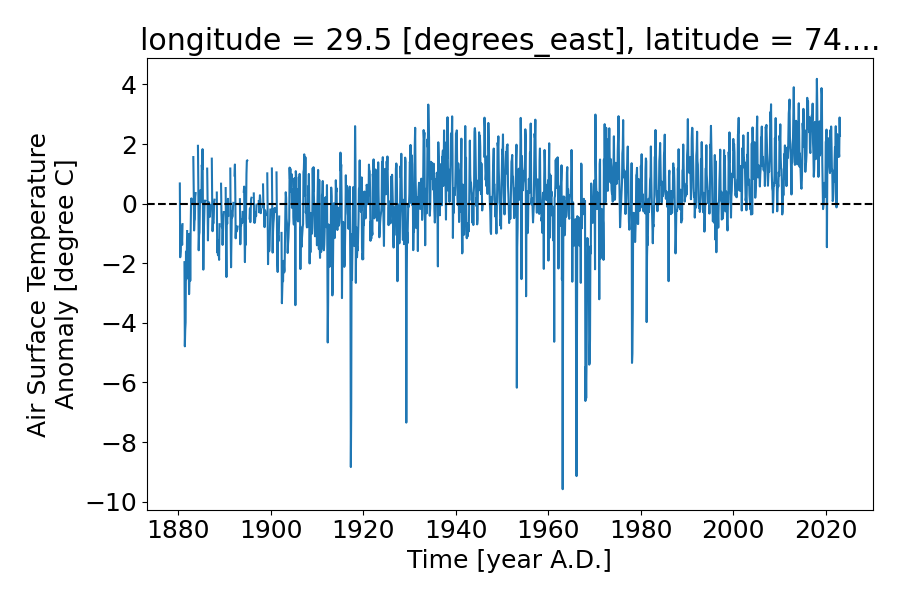

In [48]:
lon = 30
lat = 75
ilon = np.argmin((ts.longitude.data - lon)**2)
ilat = np.argmin((ts.latitude.data - lat)**2)
lon = ts.longitude.data[ilon]
lat = ts.latitude.data[ilat]

plt.close(9)
fig,ax = plt.subplots(num=9, figsize=(9,6))
ts.temperature.isel(longitude=ilon, latitude=ilat).plot()

plt.axhline(0, linestyle='dashed', color='black')

fig.tight_layout()

# Detrend

## Global mean temperature dataset

### Make the file readable by pandas

In [ ]:
with open('HEAVY--global_temp-sea_ice_from_air.txt', 'r') as orig:
    with open('HEAVY--global_temp-sea_ice_from_air.csv', 'w') as dest:
        for line in orig.readlines():
            if line.startswith('%'):
                line = f'#{line[1:]}'
            else:
                line = ','.join(filter(lambda x: x != '', line.split(' ')))
            dest.write(line)

### Load the data

In [ ]:
df = pd.read_csv('HEAVY--global_temp-sea_ice_from_air.csv', sep=',', comment='#')
df['time'] = df['year'] + (df['month'] - 0.5)/12

df = df.loc[df['time'] >= first_year]
assert len(df) == ts.time.shape[0]
df

In [ ]:
global_mean = xr.DataArray(df['a-m'], coords=[ts.time], name='global_mean')
global_mean

In [ ]:
plt.close(9)
fig,ax = plt.subplots(num=9, figsize=(9,6))
global_mean.plot()

# plt.xlabel('time [yr]')
# plt.ylabel('Global mean temperature anomaly [C]')

plt.axhline(0, linestyle='dashed', color='black')

fig.tight_layout()

In [ ]:
lon = 0
lat = 78
ilon = np.argmin((ts.longitude.data - lon)**2)
ilat = np.argmin((ts.latitude.data - lat)**2)
lon = ts.longitude.data[ilon]
lat = ts.latitude.data[ilat]

plt.close(10)
fig,ax = plt.subplots(num=10, figsize=(9,6))
plt.scatter(df['a-m'], ts.temperature.isel(longitude=ilon, latitude=ilat).data, alpha=0.5)
# plt.scatter(df['a-m'], final_temperature.isel(longitude=ilon, latitude=ilat).data, alpha=0.5)

plt.axhline(0, color='black', linestyle='dashed')

fig.tight_layout()

### Compute trends

In [ ]:
def regress(t):
    mask = np.isnan(t.data)
    x = global_mean[~mask]
    y = t[~mask]
    assert x.shape == y.shape
    res = linregress(x, y)
    return res.slope, res.intercept

In [ ]:
res = xr.apply_ufunc(regress, ts.temperature, input_core_dims=[['time']], output_core_dims=[[],[]], vectorize=True)

In [ ]:
reg = xr.Dataset({'slope': res[0], 'intercept': res[1]})
reg

In [ ]:
reg.to_netcdf(f'HEAVY--regression-{first_year}-.nc')

In [ ]:
reg = xr.open_dataset(f'HEAVY--regression-{first_year}-.nc')

In [ ]:
cplt.mfp(LON, LAT, np.stack([reg['slope'].data,reg['intercept'].data], axis=-1),
         figsize=(12,12),
         one_fig_layout=(2,1),
         # draw_coastlines=False,
         projections=cplt.ccrs.PlateCarree(),
         colorbar='individual',
         extents=None,
         titles=['Slope', 'Intercept [C]'],
         draw_labels=True,
         draw_gridlines=True
        )

In [ ]:
lon = 0
lat = 78
ilon = np.argmin((ts.longitude.data - lon)**2)
ilat = np.argmin((ts.latitude.data - lat)**2)
lon = ts.longitude.data[ilon]
lat = ts.latitude.data[ilat]

plt.close(10)
fig,ax = plt.subplots(num=10, figsize=(9,6))
plt.scatter(global_mean.data, ts.temperature.isel(longitude=ilon, latitude=ilat).data, alpha=0.5)
ax.set_xlim(*ax.get_xlim())
x = np.array(ax.get_xlim())
plt.plot(x, reg.intercept.isel(longitude=ilon, latitude=ilat).data + reg.slope.isel(longitude=ilon, latitude=ilat).data*x, color='orange')
# plt.scatter(df['a-m'], detrended_temperature.isel(longitude=ilon, latitude=ilat).data, alpha=0.5)
# plt.scatter(df['a-m'], final_temperature.isel(longitude=ilon, latitude=ilat).data, alpha=0.5)

plt.axhline(0, color='black', linestyle='dashed')
plt.axvline(0, color='black', linestyle='dashed')

plt.xlabel('global mean temperature anomaly [C]')
plt.ylabel(f'Temperature anomaly [C]' )
plt.title(f'{lon = }, {lat = }')

fig.tight_layout()

### Remove trend

In [ ]:
detrended_temperature = ts.temperature - reg.intercept - reg.slope*global_mean
detrended_temperature

### Is there a residual seasonal cycle?

In [ ]:
seasonal = ts.climatology.data.copy()
for i in range(12):
    seasonal[i] = np.nanmean(detrended_temperature[i::12], axis=0)
    # seasonal[i] = np.nanmean(final_temperature[i::12], axis=0)
seasonal = xr.DataArray(seasonal, coords=ts.climatology.coords)
seasonal

In [ ]:
months=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
ofl = (4,3)
ims = cplt.mfp(LON, LAT, seasonal.data.transpose(1,2,0),
               figsize=(16,9),
               one_fig_layout=ofl,
               # draw_coastlines=False,
               projections=cplt.ccrs.PlateCarree(),
               colorbar='shared',
               put_colorbar=False,
               extents=None,
               titles=months,
              )

plt.close(3)
fig,ax = plt.subplots(num=3, figsize=(10,2))
plt.colorbar(ims[0],cax=ax,orientation='horizontal', extend='both', label='T [C]')
fig.tight_layout()

In [ ]:
seasonal_mean = seasonal.mean('month_number')

In [ ]:
cplt.mfp(LON, LAT, seasonal_mean.data.reshape(*seasonal_mean.shape,1),
         figsize=(12,6),
         # draw_coastlines=False,
         projections=cplt.ccrs.PlateCarree(),
         colorbar='shared',
         extents=None,
         titles=['Annual mean temperature [C]'],
         draw_labels=True,
         draw_gridlines=True
        )

In [ ]:
ofl = (4,3)
ims = cplt.mfp(LON, LAT, (seasonal - seasonal_mean).data.transpose(1,2,0),
               figsize=(16,9),
               one_fig_layout=ofl,
               # draw_coastlines=False,
               projections=cplt.ccrs.PlateCarree(),
               colorbar='shared',
               put_colorbar=False,
               extents=None,
               titles=months,
              )

plt.close(3)
fig,ax = plt.subplots(num=3, figsize=(10,2))
plt.colorbar(ims[0],cax=ax,orientation='horizontal', extend='both', label='T [C]')
fig.tight_layout()

### Remove the residual seasonal cycle

In [ ]:
final_temperature = detrended_temperature.data.copy()
for i in range(12):
    final_temperature[i::12] -= seasonal.data[i]
    
final_temperature = xr.DataArray(final_temperature, coords=detrended_temperature.coords)
final_temperature

## Rolling mean

In [ ]:
annual_smoothed = detrended_temperature.rolling(time=12, center=False).mean()
annual_smoothed

## Differencing

In [ ]:
differenced = detrended_temperature - detrended_temperature.shift(time=12)

## Differencing with long term preservation

In [ ]:
resid = detrended_temperature - annual_smoothed
resid = resid - resid.shift(time=12)
resid = resid + annual_smoothed

In [ ]:
lon = -6
lat = 75
ilon = np.argmin((ts.longitude.data - lon)**2)
ilat = np.argmin((ts.latitude.data - lat)**2)
lon = ts.longitude.data[ilon]
lat = ts.latitude.data[ilat]

plt.close(9)
fig,ax = plt.subplots(num=9, figsize=(9,6))
ts.temperature.isel(longitude=ilon, latitude=ilat).plot(label='original')
detrended_temperature.isel(longitude=ilon, latitude=ilat).plot(label='detrended')
final_temperature.isel(longitude=ilon, latitude=ilat).plot(label='removing climatology')
# annual_smoothed.isel(longitude=ilon, latitude=ilat).plot(label='annual smoothing')
# differenced.isel(longitude=ilon, latitude=ilat).plot(label='differenced')
# resid.isel(longitude=ilon, latitude=ilat).plot(label='weird')

plt.axhline(0, linestyle='dashed', color='black')

plt.legend()

fig.tight_layout()

In [ ]:
plt.close(9)
fig,ax = plt.subplots(num=9, figsize=(9,6))
# detrended_temperature.isel(longitude=ilon, latitude=ilat).plot(label='original')
# final_temperature.isel(longitude=ilon, latitude=ilat).plot(label='removing climatology')
# annual_smoothed.isel(longitude=ilon, latitude=ilat).plot(label='annual smoothing')
(resid.isel(longitude=ilon, latitude=ilat) - differenced.isel(longitude=ilon, latitude=ilat)).plot()


plt.axhline(0, linestyle='dashed', color='black')


fig.tight_layout()

## Month-wise rolling mean

In [49]:
def month_wise_rolling_mean(da, window, center=True):
    months_per_year = 12
    # if min_periods is None:
    #     min_periods=window
    if center:
        left_edge = -window//2
    else:
        left_edge = 0
    right_edge = left_edge + window
    
    dout = xr.zeros_like(da)
    
    for i in tqdm(range(da.data.shape[0])):
        left_i = max(0, i + left_edge*months_per_year)
        right_i = min(i + right_edge*months_per_year, da.data.shape[0] - 1)
        # print(left_i, right_i)
        dout.data[i] = np.nanmean(da.data[left_i:right_i:months_per_year], axis=0)
        
    return dout

In [50]:
trend_10 = month_wise_rolling_mean(ts.temperature, 10)

detrend_10 = ts.temperature - trend_10

  0%|          | 0/1718 [00:00<?, ?it/s]

/tmp/ipykernel_11484/3514499584.py:17: RuntimeWarning: Mean of empty slice
  dout.data[i] = np.nanmean(da.data[left_i:right_i:months_per_year], axis=0)


### Plot a few timeseries

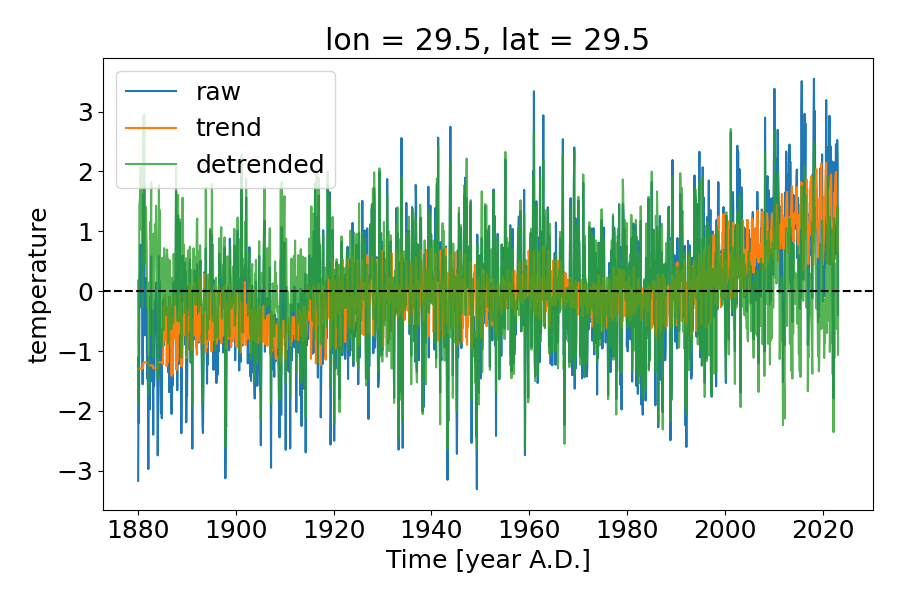

In [54]:
lon = 30
# lat = 75
lat = 30
ilon = np.argmin((ts.longitude.data - lon)**2)
ilat = np.argmin((ts.latitude.data - lat)**2)
lon = ts.longitude.data[ilon]
lat = ts.latitude.data[ilat]

plt.close(9)
fig,ax = plt.subplots(num=9, figsize=(9,6))
ts.temperature.isel(longitude=ilon, latitude=ilat).plot(label='raw')
trend_10.isel(longitude=ilon, latitude=ilat).plot(label='trend')
detrend_10.isel(longitude=ilon, latitude=ilat).plot(alpha=0.8, label='detrended')

plt.axhline(0, linestyle='dashed', color='black')

plt.title(f'{lon = }, {lat = }')
plt.legend()

fig.tight_layout()

### Check the spectrum

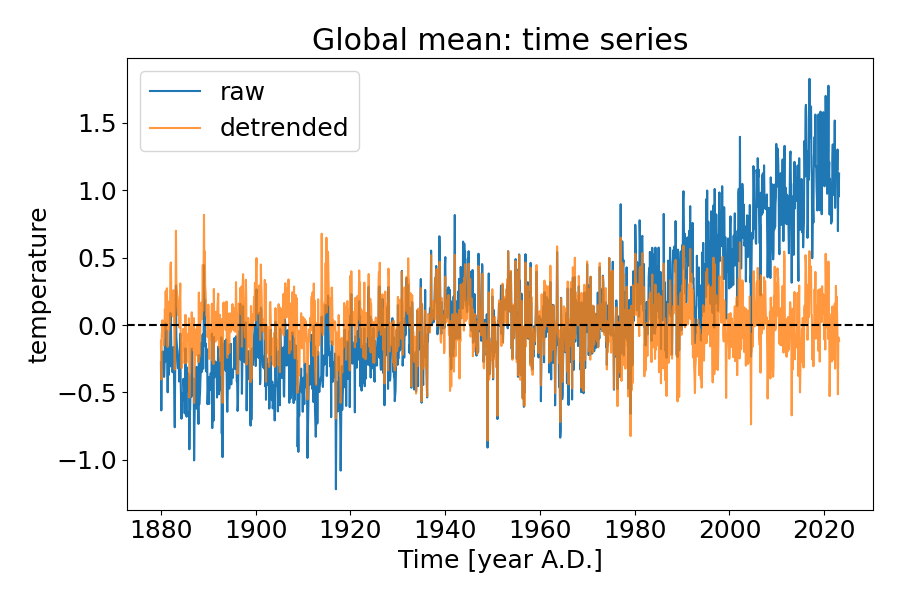

In [82]:
glob_mean = ts.temperature.mean(['longitude', 'latitude'])
glob_mean_d = detrend_10.mean(['longitude', 'latitude'])
prefix='Global mean'

# lon = 30
# # lat = 75
# lat = 30
# ilon = np.argmin((ts.longitude.data - lon)**2)
# ilat = np.argmin((ts.latitude.data - lat)**2)
# lon = ts.longitude.data[ilon]
# lat = ts.latitude.data[ilat]
# glob_mean = ts.temperature.isel(longitude=ilon, latitude=ilat)
# glob_mean_d = detrend_10.isel(longitude=ilon, latitude=ilat)
# prefix = f'{lon = }, {lat = }'


plt.close(9)
fig,ax = plt.subplots(num=9, figsize=(9,6))
glob_mean.plot(label='raw')
glob_mean_d.plot(alpha=0.8, label='detrended')

plt.axhline(0, linestyle='dashed', color='black')

plt.title(f'{prefix}: time series')
plt.legend()

fig.tight_layout()

In [56]:
from scipy import fft

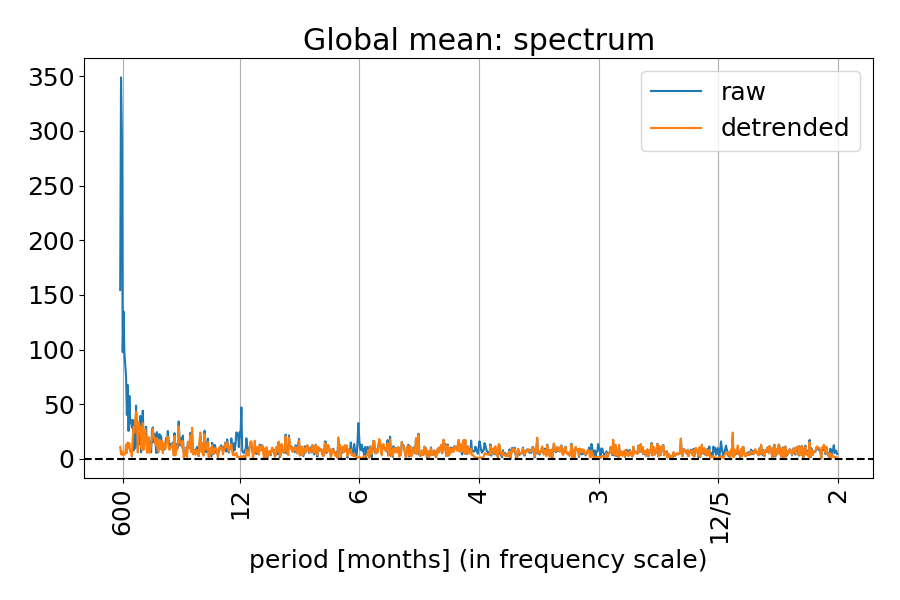

In [104]:
N = glob_mean.data.shape[0]
fft_raw = np.abs(fft.fft(glob_mean.data))[:N//2]
fft_d = np.abs(fft.fft(glob_mean_d.data))[:N//2]
freq = fft.fftfreq(N)[:N//2]

plt.close(10)
fig,ax = plt.subplots(num=10, figsize=(9,6))

plt.plot(freq, fft_raw, label='raw')
plt.plot(freq, fft_d, label='detrended')
plt.axhline(0, linestyle='dashed', color='black')


months = [2, 2.4, 3, 4, 6, 12, 50*12]
freq = [1/i for i in months]
label = [str(i) if isinstance(i,int) else '12/5' for i in months]
plt.xticks(freq,label,rotation = 90)
plt.xlabel('period [months] (in frequency scale)')
plt.legend()
plt.title(f'{prefix}: spectrum')
plt.grid(axis='x')
fig.tight_layout()

# Save the final product

In [102]:
detrend_10.to_netcdf(f'HEAVY--detrended_temperature_{first_year}-10y_mrm.nc')